# Hourly temperature forecasting (Porto): Extra SARIMAX MODELS

Out of curiosity we decided to explore more SARIMAX models other than the one we did: SARIMAX (adding annual-cycle features using Fourier terms).

We tested 2 new approaches:
- SARIMAX_meteo: with other weather variables (cradiation, windspeed, humidity)
- SARIMAX_hybrid: with meteo features + the annual-cycle features


In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

# Plot defaults
plt.rcParams.update({
    "figure.figsize": (12, 4.5),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.frameon": False,
})

In [2]:
DATA_PATH = Path("porto_weather_air_quality_5y.csv")

def load_data(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values("time").set_index("time")

    # Regular hourly grid (important for ARIMA-family models)
    
    df = df.asfreq("h")

    return df

df = load_data(DATA_PATH)
print("Shape:", df.shape)
y = df["temperature_2m"].astype(float)

Shape: (43848, 30)


## Stationarity checks (ADF and KPSS) and ACF and PACF tests for order selection

Previously, by the results of these tests we selected the best SARIMAX model:

- SARIMAX(2, 0, 1)(1, 1, 1, 24)

So we will conduct our extra tests on this base model.

## Train/test splits and accuracy metrics

We report MAE and RMSE for interpretability in temperature units. MAPE can be unstable when the denominator is near zero, so we also compute sMAPE as a more robust relative metric.


In [3]:
# Train/test split: last 5% as test set (time-ordered)
split_idx = int(len(y) * 0.95)
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print("Train size:", len(y_train))
print("Test size :", len(y_test))
print("Train period:", y_train.index.min(), "to", y_train.index.max())
print("Test period :", y_test.index.min(), "to", y_test.index.max())

def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def smape(y_true, y_pred, eps: float = 1e-6) -> float:
    denom = (np.abs(y_true) + np.abs(y_pred) + eps)
    return float(200 * np.mean(np.abs(y_true - y_pred) / denom))

HORIZONS = {"24h": 24, "48h": 48, "7d": 168, "2weeks": 336}

Train size: 41655
Test size : 2193
Train period: 2020-11-20 00:00:00 to 2025-08-21 14:00:00
Test period : 2025-08-21 15:00:00 to 2025-11-20 23:00:00


## SARIMAX (adding weather variables)

We have seen that adding the Fourier (annual) helps on larger horizons.

What if we also add other weather variables like cloud cover, wind to SARIMAX?

First lets see what variables are correlated with our target "temperature_2m" variable.

All-NaN columns in train: ['wind_speed_80m', 'wind_direction_80m']


,pearson,spearman
aerosol_optical_depth,0.194794,0.250938
apparent_temperature,0.969877,0.967424
carbon_monoxide,-0.306204,-0.336417
cloud_cover,-0.084613,-0.082928
cloud_cover_high,-0.049918,-0.051840
cloud_cover_low,-0.079213,-0.096889
cloud_cover_mid,-0.146262,-0.163916
dew_point_2m,0.759186,0.790066
diffuse_radiation,0.442749,0.482899
direct_radiation,0.562979,0.521307


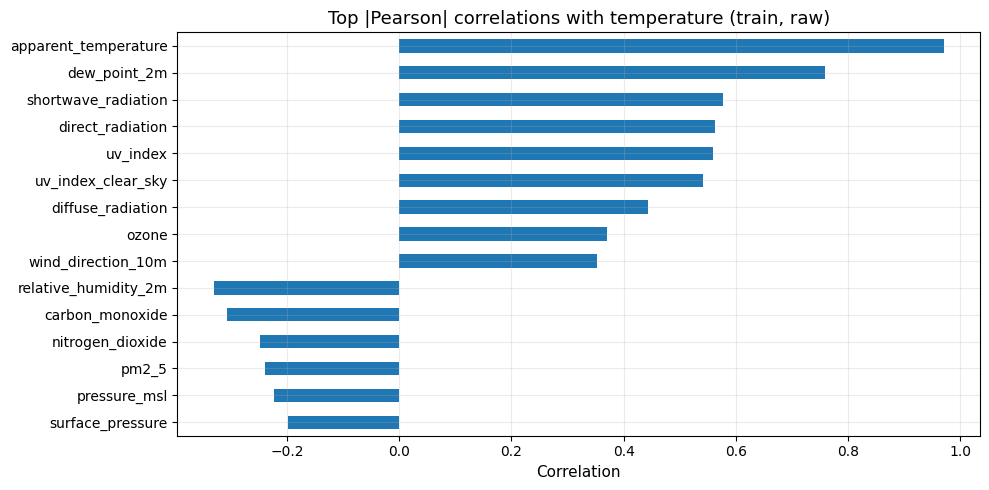

apparent_temperature    0.853387
relative_humidity_2m   -0.390706
dew_point_2m            0.364631
ozone                   0.231244
wind_speed_10m          0.231116
pressure_msl           -0.208280
dust                    0.193413
surface_pressure       -0.189121
direct_radiation        0.175714
nitrogen_dioxide       -0.171676
shortwave_radiation     0.164672
carbon_monoxide        -0.159048
uv_index                0.126406
pm2_5                  -0.121425
cloud_cover_mid         0.118042
dtype: float64

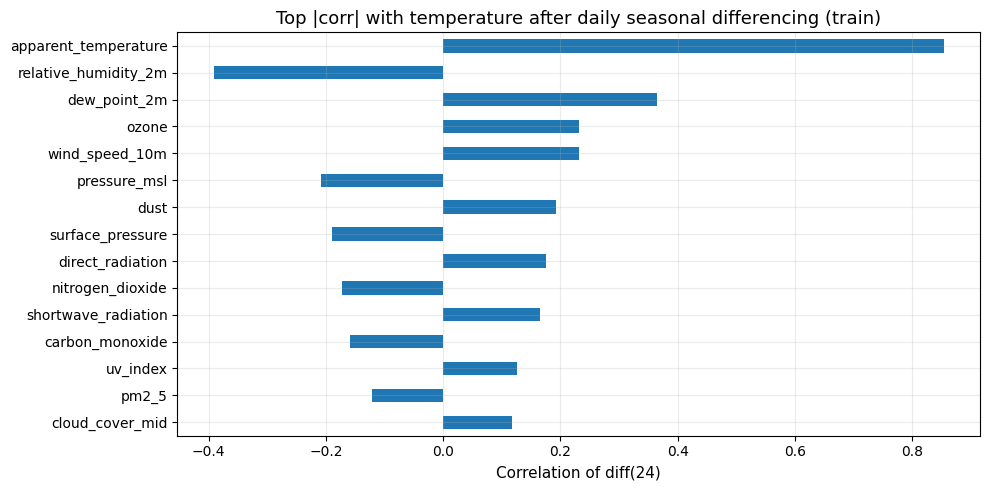

In [4]:
TARGET = "temperature_2m"

# Use TRAIN only
df_train = df.iloc[:split_idx].copy()

# Drop columns that are all missing in train
all_nan = df_train.columns[df_train.isna().all()].tolist()
print("All-NaN columns in train:", all_nan)

df_train = df_train.drop(columns=all_nan)

# Candidate exog columns: everything except target
cand_cols = [c for c in df_train.columns if c != TARGET]

# Raw correlations (Pearson + Spearman)
pearson = df_train[cand_cols].corrwith(df_train[TARGET], method="pearson").sort_values(key=np.abs, ascending=False)
spearman = df_train[cand_cols].corrwith(df_train[TARGET], method="spearman").sort_values(key=np.abs, ascending=False)

corr_tbl = pd.DataFrame({"pearson": pearson, "spearman": spearman})
display(corr_tbl.head(15))

plt.figure(figsize=(10, 5))
pearson.head(15).iloc[::-1].plot(kind="barh")
plt.title("Top |Pearson| correlations with temperature (train, raw)")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()

# De-seasonalized (daily) correlations
y_d24 = df_train[TARGET].diff(24)

d24_corrs = {}
for c in cand_cols:
    x_d24 = df_train[c].diff(24)
    d24_corrs[c] = y_d24.corr(x_d24)

d24_corr = pd.Series(d24_corrs).sort_values(key=np.abs, ascending=False)
display(d24_corr.head(15))

plt.figure(figsize=(10, 5))
d24_corr.head(15).iloc[::-1].plot(kind="barh")
plt.title("Top |corr| with temperature after daily seasonal differencing (train)")
plt.xlabel("Correlation of diff(24)")
plt.tight_layout()
plt.show()

We computed correlations between temperature and candidate covariates using (i) the raw training data and (ii) daily seasonally differenced series (diff(24)) to reduce spurious correlation driven purely by the diurnal cycle.

We selected a small set of meteorological variables that show consistent association with temperature and are physically meaningful: shortwave radiation, relative humidity, 10 m wind speed, and mean sea-level pressure.

We explicitly excluded variables that effectively “leak” temperature information or are near-derived transforms of temperature (e.g., apparent temperature and dew point), and we avoided using multiple highly collinear radiation indicators at once.

In [5]:
EXOG_VARS = [
    "shortwave_radiation",
    "relative_humidity_2m",
    "wind_speed_10m",
    "pressure_msl",
]

exog = df[EXOG_VARS].copy()
exog_train = exog.iloc[:split_idx]
exog_test  = exog.iloc[split_idx:]

scaler = StandardScaler()
exog_train_s = pd.DataFrame(
    scaler.fit_transform(exog_train),
    index=exog_train.index,
    columns=EXOG_VARS,
)
exog_test_s = pd.DataFrame(
    scaler.transform(exog_test),
    index=exog_test.index,
    columns=EXOG_VARS,
)

In [6]:
sarimax_model = SARIMAX(
    y_train,
    exog=exog_train_s,
    order=(2, 0, 1),
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

# If you hit MemoryError, use: fit(disp=False, low_memory=True)
sarimax_results_meteo = sarimax_model.fit(disp=False)

print(sarimax_results_meteo.summary())


c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                     temperature_2m   No. Observations:                41655
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -22087.057
Date:                            Sun, 21 Dec 2025   AIC                          44194.113
Time:                                    23:49:55   BIC                          44280.473
Sample:                                11-20-2020   HQIC                         44221.398
                                     - 08-21-2025                                         
Covariance Type:                              opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
shortwave_radiation      0.6138      0.008     72.351      0.000       0.597       0.630
relat

In [7]:
rows = []
for label, h in HORIZONS.items():
    fc = sarimax_results_meteo.get_forecast(steps=h, exog=exog_test_s.iloc[:h]).predicted_mean
    fc.index = y_test.index[:h]
    y_true = y_test.iloc[:h]
    rows.append(["SARIMAX (meteo only)", label, mean_absolute_error(y_true, fc), rmse(y_true, fc)])

sarimax_meteo_h = pd.DataFrame(rows, columns=["Model", "Horizon", "MAE", "RMSE"])
display(sarimax_meteo_h)

,Model,Horizon,MAE,RMSE
0,SARIMAX (meteo only),24h,0.676969,0.819442
1,SARIMAX (meteo only),48h,0.607038,0.729078
2,SARIMAX (meteo only),7d,1.459559,1.741306
3,SARIMAX (meteo only),2weeks,1.548043,1.862024


## SARIMAX (meteo variables + annual-cycle features)

We also decided to test SARIMAX that uses both the meteo variables and the Fourier annual-cycle features to see if an hybrid approach has positive effects.

In [8]:
def make_fourier_exog(index: pd.DatetimeIndex, period_hours: float, K: int, origin) -> pd.DataFrame:
    t = (index - origin).total_seconds() / 3600.0
    data = {}
    for k in range(1, K + 1):
        data[f"sin_{k}"] = np.sin(2 * np.pi * k * t / period_hours)
        data[f"cos_{k}"] = np.cos(2 * np.pi * k * t / period_hours)
    return pd.DataFrame(data, index=index)

period_year = 365.25 * 24  # ~8766 hours
K = 1
origin = y.index[0]  # or y_train.index[0] (either is fine as long as consistent)

fourier_train = make_fourier_exog(y_train.index, period_year, K, origin)
fourier_test  = make_fourier_exog(y_test.index,  period_year, K, origin)

In [9]:
EXOG_VARS = [
    "shortwave_radiation",
    "relative_humidity_2m",
    "wind_speed_10m",
    "pressure_msl",
]

exog_meteo = df[EXOG_VARS].copy()
exog_train = exog_meteo.iloc[:split_idx]
exog_test  = exog_meteo.iloc[split_idx:]

scaler = StandardScaler()
exog_train_s = pd.DataFrame(scaler.fit_transform(exog_train), index=exog_train.index, columns=EXOG_VARS)
exog_test_s  = pd.DataFrame(scaler.transform(exog_test),  index=exog_test.index,  columns=EXOG_VARS)

# Combine meteo + Fourier (align by index)
exog_train_combo = pd.concat([exog_train_s, fourier_train], axis=1)
exog_test_combo  = pd.concat([exog_test_s,  fourier_test],  axis=1)

# Optional sanity checks (recommended once)
assert exog_train_combo.index.equals(y_train.index)
assert exog_test_combo.index.equals(y_test.index)

# Fit SARIMAX with combined exog
sarimax_model_combo = SARIMAX(
    y_train,
    exog=exog_train_combo,
    order=(2, 0, 1),
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

# If you hit MemoryError, switch to: fit(disp=False, low_memory=True)
sarimax_results_combo = sarimax_model_combo.fit(disp=False)

print(sarimax_results_combo.summary())

c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                     temperature_2m   No. Observations:                41655
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -22070.529
Date:                            Sun, 21 Dec 2025   AIC                          44165.057
Time:                                    23:59:26   BIC                          44268.689
Sample:                                11-20-2020   HQIC                         44197.799
                                     - 08-21-2025                                         
Covariance Type:                              opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
shortwave_radiation      0.6244      0.008     73.472      0.000       0.608       0.641
relat

In [10]:
rows = []
for label, h in HORIZONS.items():
    fc = sarimax_results_combo.get_forecast(
        steps=h,
        exog=exog_test_combo.iloc[:h]
    ).predicted_mean
    fc.index = y_test.index[:h]
    y_true = y_test.iloc[:h]
    rows.append(["SARIMAX (meteo + Fourier annual)", label,
                 mean_absolute_error(y_true, fc), rmse(y_true, fc)])

sarimax_combo_h = pd.DataFrame(rows, columns=["Model", "Horizon", "MAE", "RMSE"])
display(sarimax_combo_h)

,Model,Horizon,MAE,RMSE
0,SARIMAX (meteo + Fourier annual),24h,0.680787,0.825502
1,SARIMAX (meteo + Fourier annual),48h,0.605404,0.726659
2,SARIMAX (meteo + Fourier annual),7d,1.363344,1.628956
3,SARIMAX (meteo + Fourier annual),2weeks,1.437138,1.726012


## 7-day comparison plot

To summarize model behavior on a realistic short horizon, we overlay observed temperature with forecasts from the SARIMAX models


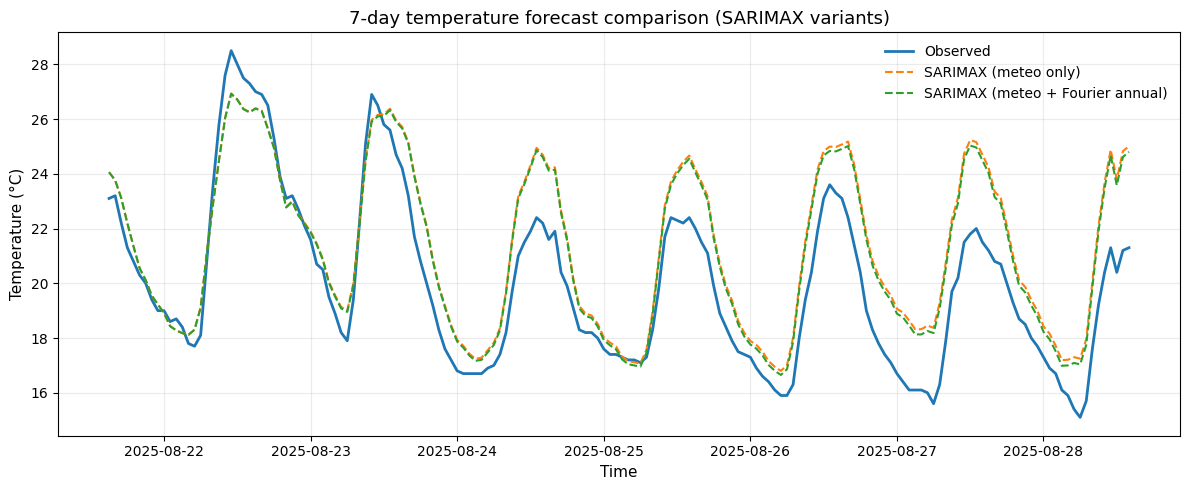

In [11]:
horizon = 168
idx = y_test.index[:horizon]

observed = y_test.iloc[:horizon]

# SARIMAX (meteo only)
sarimax_meteo_mean = sarimax_results_meteo.get_forecast(
    steps=horizon,
    exog=exog_test_s.iloc[:horizon]
).predicted_mean
sarimax_meteo_mean.index = idx

# SARIMAX (meteo + annual Fourier)
sarimax_combo_mean = sarimax_results_combo.get_forecast(
    steps=horizon,
    exog=exog_test_combo.iloc[:horizon]
).predicted_mean
sarimax_combo_mean.index = idx

plt.figure(figsize=(12, 5))
plt.plot(observed, label="Observed", linewidth=2)
plt.plot(sarimax_meteo_mean, label="SARIMAX (meteo only)", linestyle="--")
plt.plot(sarimax_combo_mean, label="SARIMAX (meteo + Fourier annual)", linestyle="--")
plt.title("7-day temperature forecast comparison (SARIMAX variants)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
tables = []

for name in ["sarimax_meteo_h", "sarimax_combo_h"]:
    if name in globals():
        tables.append(globals()[name].copy())
    else:
        print(f"Missing: {name}")

all_models_h = pd.concat(tables, ignore_index=True)

h_order = list(HORIZONS.keys())

comparison = (all_models_h
              .pivot_table(index="Model", columns="Horizon", values=["MAE", "RMSE"], aggfunc="mean")
              .reindex(columns=pd.MultiIndex.from_product([["MAE", "RMSE"], h_order]))
              .round(3))

display(comparison)

MAE                        RMSE         \
                                    24h    48h     7d 2weeks    24h    48h   
Model                                                                        
SARIMAX (meteo + Fourier annual)  0.681  0.605  1.363  1.437  0.826  0.727   
SARIMAX (meteo only)              0.677  0.607  1.460  1.548  0.819  0.729   

                                                
                                     7d 2weeks  
Model                                           
SARIMAX (meteo + Fourier annual)  1.629  1.726  
SARIMAX (meteo only)              1.741  1.862

## 10-fold Cross validation on all models

In [13]:
def _sample_test_starts(n_test, h, n_windows=10, seed=42):
    rng = np.random.default_rng(seed + h)
    eligible = np.arange(0, n_test - h + 1)
    k = min(n_windows, len(eligible))
    return np.sort(rng.choice(eligible, size=k, replace=False))

def test_windows_cv_two_sarimax(
    y_train,
    y_test,
    HORIZONS,
    sarimax_results_meteo,
    exog_test_s,
    sarimax_results_combo,
    exog_test_combo,
    n_windows=10,
    seed=42,
    verbose=True
):
    rows = []

    for h_label, h in HORIZONS.items():
        starts = _sample_test_starts(len(y_test), h, n_windows=n_windows, seed=seed)

        # SARIMAX (meteo only)
        if verbose: print(f"Tested on {h_label} for model SARIMAX (meteo only)")
        for s in starts:
            idx = y_test.index[s:s+h]
            y_true = y_test.iloc[s:s+h]

            res_ext = (sarimax_results_meteo.append(
                y_test.iloc[:s],
                exog=exog_test_s.iloc[:s],
                refit=False
            ) if s > 0 else sarimax_results_meteo)

            yhat = res_ext.get_forecast(
                steps=h,
                exog=exog_test_s.iloc[s:s+h]
            ).predicted_mean
            yhat.index = idx

            rows.append({
                "Model": "SARIMAX (meteo only)",
                "Horizon": h_label,
                "MAE": mean_absolute_error(y_true, yhat),
                "RMSE": rmse(y_true, yhat)
            })

        # SARIMAX (meteo + Fourier annual)
        if verbose: print(f"Tested on {h_label} for model SARIMAX (meteo + Fourier annual)")
        for s in starts:
            idx = y_test.index[s:s+h]
            y_true = y_test.iloc[s:s+h]

            res_ext = (sarimax_results_combo.append(
                y_test.iloc[:s],
                exog=exog_test_combo.iloc[:s],
                refit=False
            ) if s > 0 else sarimax_results_combo)

            yhat = res_ext.get_forecast(
                steps=h,
                exog=exog_test_combo.iloc[s:s+h]
            ).predicted_mean
            yhat.index = idx

            rows.append({
                "Model": "SARIMAX (meteo + Fourier annual)",
                "Horizon": h_label,
                "MAE": mean_absolute_error(y_true, yhat),
                "RMSE": rmse(y_true, yhat)
            })

    cv = pd.DataFrame(rows)

    h_order = list(HORIZONS.keys())
    cv_mean = cv.groupby(["Model", "Horizon"])[["MAE", "RMSE"]].mean().reset_index()

    comparison_cv = (cv_mean
        .pivot_table(index="Model", columns="Horizon", values=["MAE", "RMSE"], aggfunc="mean")
        .reindex(columns=pd.MultiIndex.from_product([["MAE", "RMSE"], h_order]))
        .round(3)
    )

    return cv, comparison_cv


cv, comparison_cv = test_windows_cv_two_sarimax(
    y_train=y_train,
    y_test=y_test,
    HORIZONS=HORIZONS,
    sarimax_results_meteo=sarimax_results_meteo,
    exog_test_s=exog_test_s,
    sarimax_results_combo=sarimax_results_combo,
    exog_test_combo=exog_test_combo,
    n_windows=10,
    seed=42,
    verbose=True
)

Tested on 24h for model SARIMAX (meteo only)
Tested on 24h for model SARIMAX (meteo + Fourier annual)
Tested on 48h for model SARIMAX (meteo only)
Tested on 48h for model SARIMAX (meteo + Fourier annual)
Tested on 7d for model SARIMAX (meteo only)
Tested on 7d for model SARIMAX (meteo + Fourier annual)
Tested on 2weeks for model SARIMAX (meteo only)
Tested on 2weeks for model SARIMAX (meteo + Fourier annual)


Now lets compare the new SARIMAX models with the SARIMAX (Fourier annual only) and SARIMA from our main script.

In [16]:
base_mae  = [1.746, 1.736, 1.957, 2.035]
base_rmse = [2.037, 2.046, 2.302, 2.401]

fourier_only_mae = [1.707, 1.593, 1.804, 1.965]
fourier_only_rmse = [2.006, 1.898, 2.142, 2.335]

h_order = list(HORIZONS.keys())

base_row = pd.DataFrame(
    [base_mae + base_rmse],
    index=["SARIMA"],
    columns=pd.MultiIndex.from_tuples(
        [("MAE", h) for h in h_order] + [("RMSE", h) for h in h_order]
    )
)

fourier_row = pd.DataFrame(
    [fourier_only_mae + fourier_only_rmse],
    index=["SARIMAX (Fourier annual only)"],
    columns=pd.MultiIndex.from_tuples(
        [("MAE", h) for h in h_order] + [("RMSE", h) for h in h_order]
    )
)

comparison_cv_plus = pd.concat([comparison_cv, fourier_row.reindex(columns=comparison_cv.columns), base_row.reindex(columns=comparison_cv.columns)]).round(3)

display(comparison_cv_plus)

MAE                        RMSE         \
                                    24h    48h     7d 2weeks    24h    48h   
SARIMAX (meteo + Fourier annual)  1.500  1.390  1.363  1.493  1.742  1.682   
SARIMAX (meteo only)              1.587  1.414  1.589  1.578  1.804  1.723   
SARIMAX (Fourier annual only)     1.707  1.593  1.804  1.965  2.006  1.898   
SARIMA                            1.746  1.736  1.957  2.035  2.037  2.046   

                                                
                                     7d 2weeks  
SARIMAX (meteo + Fourier annual)  1.670  1.825  
SARIMAX (meteo only)              1.884  1.866  
SARIMAX (Fourier annual only)     2.142  2.335  
SARIMA                            2.302  2.401

## Summary

As expected, enriching the baseline **SARIMA** with additional structure improves performance. **SARIMAX (meteo only)** lowers both MAE and RMSE at every horizon, showing that meteorological exogenous variables add real predictive signal beyond the autoregressive dynamics. Adding **annual Fourier terms on top of meteo** performs best overall, achieving the lowest errors across all horizons, which suggests the Fourier features capture remaining seasonal structure not fully explained by meteo. **Fourier-only SARIMAX** improves over SARIMA (especially at longer horizons) but is consistently weaker than meteo-based SARIMAX, indicating seasonality alone is helpful but not sufficient. Overall, the best results come from combining **exogenous meteo drivers + seasonal Fourier components**.
